In [83]:
!pip install -U jax jaxlib
!pip install scikit-learn
!pip install pandas
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import warnings
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd 
# %matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')


dataset_path = 'train/'

# Create data generator
IMG_WIDTH = 28
IMG_HEIGHT = 28
BATCH_SIZE = 32

print(tf.config.list_physical_devices('GPU'))

In [3]:
train_df = pd.read_csv('train/sign_mnist_train.csv')
test_df = pd.read_csv('test/sign_mnist_test.csv')

In [4]:
y_train = train_df['label']
y_test = test_df['label']

x_train = train_df.drop('label',axis=1)
x_train = np.array(x_train,dtype='float32')/255

x_test = test_df.drop('label',axis=1)
x_test = np.array(x_test,dtype='float32')/255

print('x_train : {}\n'.format(x_train[:]))
print('Y-train shape: {}\n'.format(y_train))
print('x_test shape: {}'.format(x_test.shape))

In [5]:
x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train, test_size=.05, random_state=1234,)

In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [7]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1)

datagen.fit(x_train)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(45, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), strides = 1, padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding = 'same'))
model.add(Conv2D(55, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=24,activation='softmax'))
    
# Compile model
optimizer = Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [9]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the file path for saving the model
filepath = "output.{epoch:02d}-{val_loss:.2f}.h5"

# Define a callback to save the model every epoch and keep the best one
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model with the checkpoint callback
initial_epoch = 0 # Set initial epoch
best_model_path = "best_model.h5" # Set best model path
latest_checkpoint_path = "latest_checkpoint.h5" # Set latest checkpoint path

# Check if there's a latest checkpoint file
if os.path.isfile(latest_checkpoint_path):
    # Load the weights of the latest checkpoint file into the model
    model.load_weights(latest_checkpoint_path)
    # Get the epoch number of the latest checkpoint file
    latest_checkpoint_epoch = int(latest_checkpoint_path.split('.')[1].split('-')[0])
    # Set the initial epoch to the epoch number of the latest checkpoint file + 1
    initial_epoch = latest_checkpoint_epoch + 1

# Train the model with the checkpoint callback starting from the initial epoch
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=15, validation_data = (x_test,y_test), callbacks = [learning_rate_reduction])

In [11]:
tf.keras.models.save_model(model, "output")

In [12]:
# Access the history metrics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [76]:
import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 21ms/step


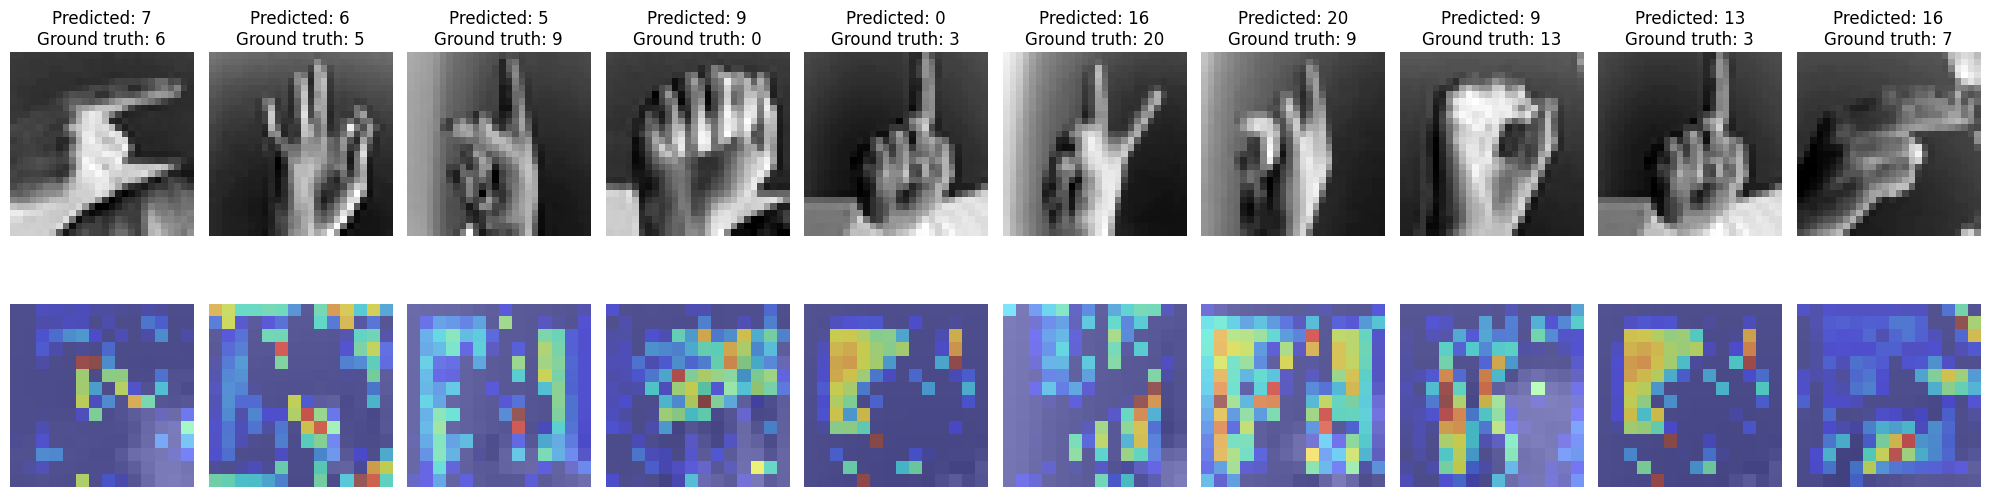

In [81]:
plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate two rows

x, y = 10, 2  # Two rows: images and Grad-CAM
for i in range(10):  
    # Labeling
    prediction = model.predict(input_image)
    predicted_label = np.argmax(prediction)
    true_label = np.argmax(y_test[i])

    
    plt.subplot(y, x, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

    plt.title(f'Predicted: {predicted_label}\nGround truth: {true_label}')
    
    # Plot the Grad-CAM on the second row
    input_image = np.expand_dims(x_test[i], axis=0)
    cam = make_gradcam_heatmap(input_image, model, "conv2d_1")
    plt.subplot(y, x, i+11)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray_r', alpha=0.5)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

225/225 [==============================] - 1s 3ms/step


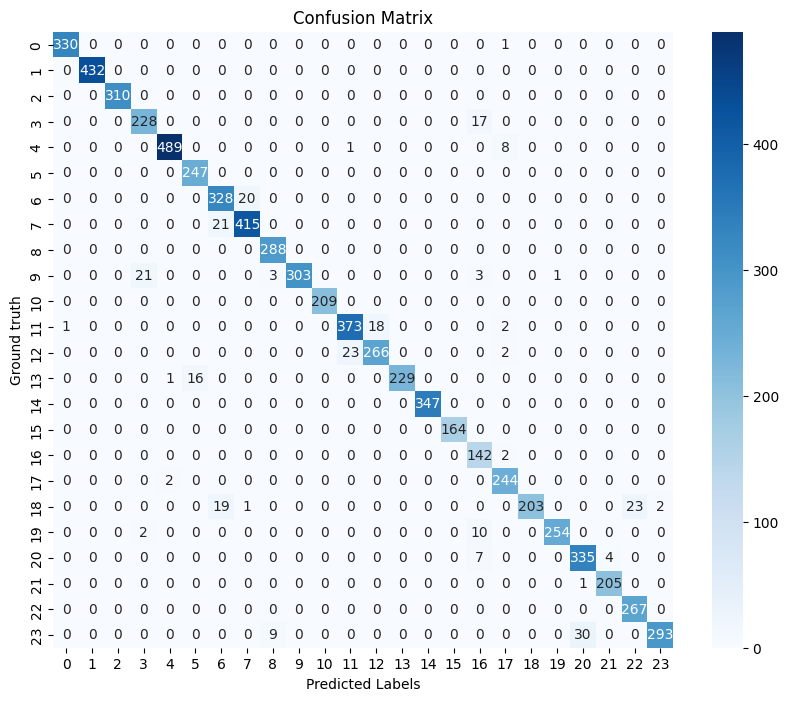

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have predictions and true labels
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix')
plt.show()